# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
sys.path.append('../')

from mrcnn.config import Config
import mrcnn.model as modellib
import mrcnn.visualize as visualize
from mrcnn.model import log
import mrcnn.shapes as shapes
from mrcnn.dataset import Dataset 

# Root directory of the project
ROOT_DIR = os.getcwd()
MODEL_PATH = 'E:/Models'
# Directory to save logs and trained model
MODEL_DIR = os.path.join(MODEL_PATH, "mrcnn_logs")

# Path to COCO trained weights
COCO_MODEL_PATH = os.path.join(MODEL_PATH, "mask_rcnn_coco.h5")
RESNET_MODEL_PATH = os.path.join(MODEL_PATH,"resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")
import tensorflow as tf
import keras
print("Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Tensorflow Version: 1.4.0   Keras Version : 2.1.3 


## Configurations

In [23]:
from keras import backend as KB
if 'tensorflow' == KB.backend():
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    tfconfig = tf.ConfigProto(
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5),
        device_count = {'GPU': 1}
    )    
#session = tf.Session(config=config)
set_session(tf.Session(config=tfconfig))

In [24]:
config = shapes.ShapesConfig()
config.display() 


Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_

## Notebook Preferences

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [7]:
# Training dataset
# generate 500 shapes 
dataset_train = shapes.ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = shapes.ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

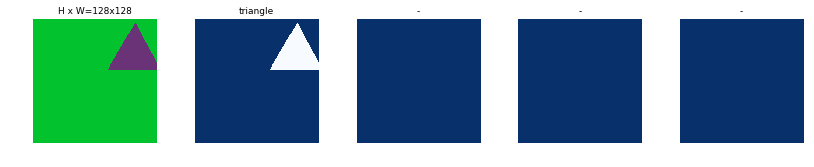

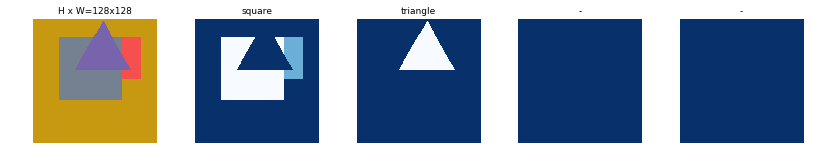

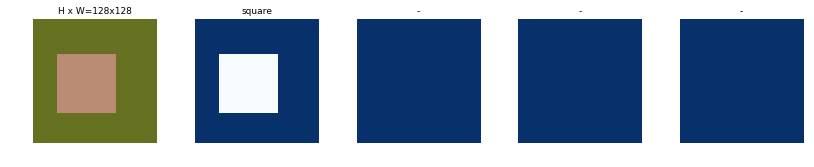

In [8]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 3)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [25]:
# import importlib
# importlib.reload(model)
# Create model in training mode
# MODEL_DIR = os.path.join(MODEL_PATH, "mrcnn_logs")
import  gc
# del history
del model.keras_model
gc.collect()

model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

 IMAGE SHAPE is : 128    128
<class 'list'>
Tensor("rpn_class_logits_1/concat:0", shape=(?, ?, 2), dtype=float32) rpn_class_logits_1/concat:0
Tensor("rpn_class_1/concat:0", shape=(?, ?, 2), dtype=float32) rpn_class_1/concat:0
Tensor("rpn_bbox_1/concat:0", shape=(?, ?, 4), dtype=float32) rpn_bbox_1/concat:0
Proposal Layer init complete. Size of anchors:  (4092, 4)
>>> MaskRCNN build complete
>>> MaskRCNN initialization complete


In [26]:
print(MODEL_PATH)
print(COCO_MODEL_PATH)
print(RESNET_MODEL_PATH)
print(MODEL_DIR)
print(model.find_last())

E:/Models
E:/Models\mask_rcnn_coco.h5
E:/Models\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
E:/Models\mrcnn_logs
('E:/Models\\mrcnn_logs\\shapes20180303T1721', None)


In [27]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
#     loc=model.load_weights(model.get_imagenet_weights(), by_name=True)
    loc=model.load_weights(RESNET_MODEL_PATH, by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    loc=model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    loc= model.load_weights(model.find_last()[1], by_name=True)


In [14]:
for i in range(len(model.keras_model.layers)):
    print(i, ' Name of layer: ', model.keras_model.layers[i].name)

0  Name of layer:  input_image
1  Name of layer:  zero_padding2d_1
2  Name of layer:  conv1
3  Name of layer:  bn_conv1
4  Name of layer:  activation_1
5  Name of layer:  max_pooling2d_1
6  Name of layer:  res2a_branch2a
7  Name of layer:  bn2a_branch2a
8  Name of layer:  activation_2
9  Name of layer:  res2a_branch2b
10  Name of layer:  bn2a_branch2b
11  Name of layer:  activation_3
12  Name of layer:  res2a_branch2c
13  Name of layer:  res2a_branch1
14  Name of layer:  bn2a_branch2c
15  Name of layer:  bn2a_branch1
16  Name of layer:  add_1
17  Name of layer:  res2a_out
18  Name of layer:  res2b_branch2a
19  Name of layer:  bn2b_branch2a
20  Name of layer:  activation_4
21  Name of layer:  res2b_branch2b
22  Name of layer:  bn2b_branch2b
23  Name of layer:  activation_5
24  Name of layer:  res2b_branch2c
25  Name of layer:  bn2b_branch2c
26  Name of layer:  add_2
27  Name of layer:  res2b_out
28  Name of layer:  res2c_branch2a
29  Name of layer:  bn2c_branch2a
30  Name of layer:  act

In [19]:
# sess = tf.InteractiveSession()
# model.keras_model.layers[229].output.eval()

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [28]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
config.STEPS_PER_EPOCH = 5
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=3, 
            layers='heads')


Starting at epoch 0 of 3 epochs. LR=0.001

  Steps per epochs 5 
Checkpoint Path: E:/Models\mrcnn_logs\shapes20180303T1727\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       

D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


*** Start of Training 1520094589.269974 
Start epoch 0  loss {}  dict_keys([])

Epoch 1/3

... Start training of batch 0 size 8 keys dict_keys(['size', 'batch'])


ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[Node: training_3/SGD/gradients/Square_364_grad/mul/x = Const[_class=["loc:@Square_364"], dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 2>, _device="/job:localhost/replica:0/task:0/device:GPU:0"](^training_3/SGD/gradients/mul_364_grad/Reshape_1)]]

Caused by op 'training_3/SGD/gradients/Square_364_grad/mul/x', defined at:
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2856, in run_ast_nodes
    if self.run_code(code, result):
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-953131452e03>", line 9, in <module>
    layers='heads')
  File "..\mrcnn\model.py", line 795, in train
    use_multiprocessing=False
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\keras\engine\training.py", line 2026, in fit_generator
    self._make_train_function()
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\keras\engine\training.py", line 970, in _make_train_function
    loss=self.total_loss)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\keras\optimizers.py", line 162, in get_updates
    grads = self.get_gradients(loss, params)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\keras\optimizers.py", line 78, in get_gradients
    grads = K.gradients(loss, params)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\keras\backend\tensorflow_backend.py", line 2512, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 581, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 353, in _MaybeCompile
    return grad_fn()  # Exit early
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 581, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\ops\math_grad.py", line 312, in _SquareGrad
    return grad * (2.0 * x)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\ops\math_ops.py", line 909, in r_binary_op_wrapper
    x = ops.convert_to_tensor(x, dtype=y.dtype.base_dtype, name="x")
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 836, in convert_to_tensor
    as_ref=False)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 926, in internal_convert_to_tensor
    ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\framework\constant_op.py", line 229, in _constant_tensor_conversion_function
    return constant(v, dtype=dtype, name=name)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\framework\constant_op.py", line 214, in constant
    name=name).outputs[0]
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'Square_364', defined at:
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 19 identical lines from previous traceback]
  File "<ipython-input-28-953131452e03>", line 9, in <module>
    layers='heads')
  File "..\mrcnn\model.py", line 783, in train
    self.compile(learning_rate, self.config.LEARNING_MOMENTUM)
  File "..\mrcnn\model.py", line 634, in compile
    for w in self.keras_model.trainable_weights
  File "..\mrcnn\model.py", line 635, in <listcomp>
    if 'gamma' not in w.name and 'beta' not in w.name]
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\keras\regularizers.py", line 42, in __call__
    regularization += K.sum(self.l2 * K.square(x))
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\keras\backend\tensorflow_backend.py", line 1432, in square
    return tf.square(x)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\ops\math_ops.py", line 449, in square
    return gen_math_ops.square(x, name=name)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 4566, in square
    "Square", x=x, name=name)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [] and type float
	 [[Node: training_3/SGD/gradients/Square_364_grad/mul/x = Const[_class=["loc:@Square_364"], dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 2>, _device="/job:localhost/replica:0/task:0/device:GPU:0"](^training_3/SGD/gradients/mul_364_grad/Reshape_1)]]


In [ ]:
# model.keras_model.summary(line_length=110)

# from keras.utils import plot_model
# plot_model(model.keras_model, to_file='model.png')

In [16]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
config.STEPS_PER_EPOCH = 5
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=4,
            layers="all")


Starting at epoch 0 of 4 epochs. LR=0.0001

  Steps per epochs 5 
Checkpoint Path: E:/Models\mrcnn_logs\shapes20180303T1705\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2

D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


*** Start of Training 1520093511.0509152 
Start epoch 0  loss {}  dict_keys([])

Epoch 1/4

... Start training of batch 0 size 8 keys dict_keys(['size', 'batch'])


ResourceExhaustedError: OOM when allocating tensor with shape[8,512,32,32]
	 [[Node: rpn_model/rpn_conv_shared/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](fpn_p2/BiasAdd, rpn_conv_shared/kernel/read)]]
	 [[Node: ROI/strided_slice_145/_4825 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_7827_ROI/strided_slice_145", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'rpn_model/rpn_conv_shared/convolution', defined at:
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-c47828c1aa63>", line 11, in <module>
    model_dir=MODEL_DIR)
  File "..\mrcnn\model.py", line 275, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "..\mrcnn\model.py", line 377, in build
    layer_outputs.append(rpn([p]))
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\keras\engine\topology.py", line 617, in __call__
    output = self.call(inputs, **kwargs)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\keras\engine\topology.py", line 2078, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\keras\engine\topology.py", line 2229, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\keras\layers\convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\keras\backend\tensorflow_backend.py", line 3332, in conv2d
    data_format=tf_data_format)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 751, in convolution
    return op(input, filter)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 835, in __call__
    return self.conv_op(inp, filter)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 499, in __call__
    return self.call(inp, filter)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 187, in __call__
    name=self.name)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 630, in conv2d
    data_format=data_format, name=name)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[8,512,32,32]
	 [[Node: rpn_model/rpn_conv_shared/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](fpn_p2/BiasAdd, rpn_conv_shared/kernel/read)]]
	 [[Node: ROI/strided_slice_145/_4825 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_7827_ROI/strided_slice_145", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))